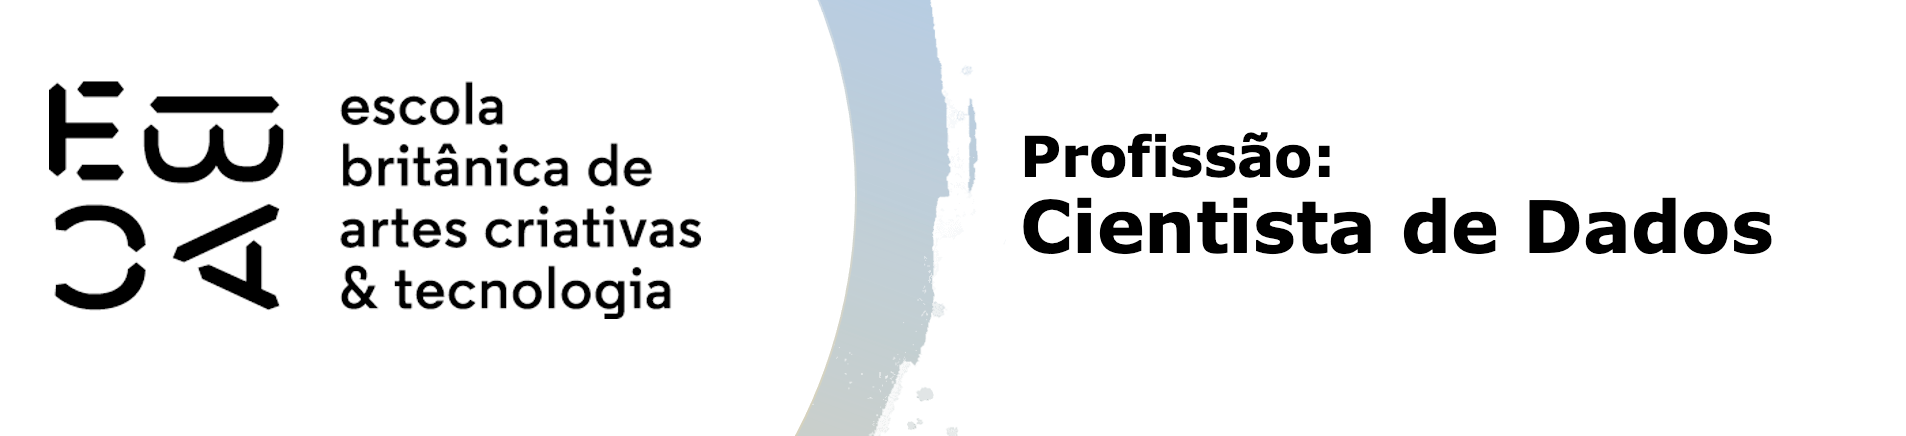

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from scipy.stats import ks_2samp
from scipy.stats import t

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
print(df.data_ref.min())
print(df.data_ref.max())

2015-01-01 00:00:00
2016-03-01 00:00:00


In [5]:
ultimos_meses = df['data_ref'].drop_duplicates().nlargest(3)

In [6]:
# criando os dois dataframes
df_oot = df[df['data_ref'].isin(ultimos_meses)]

df_treino = df[~df['data_ref'].isin(ultimos_meses)]

In [7]:
print(f"Tamanho do conjunto de validação (oot): {df_oot.shape[0]}")
print(f"Tamanho do conjunto de treinamento: {df_treino.shape[0]}")

Tamanho do conjunto de validação (oot): 150000
Tamanho do conjunto de treinamento: 600000


In [8]:
df_treino

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,2015-12-01,2205,F,S,N,0,Assalariado,Médio,União,Casa,47,23.690411,2.0,11009.92,False
599996,2015-12-01,1266,M,S,N,1,Empresário,Superior completo,Casado,Casa,31,3.756164,3.0,4472.60,False
599997,2015-12-01,13085,F,N,N,0,Pensionista,Médio,Casado,Casa,62,NaN,2.0,5117.17,True
599998,2015-12-01,10964,F,N,N,0,Assalariado,Superior completo,Casado,Casa,40,12.939726,2.0,2885.45,True


In [9]:
df_oot

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,False
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [10]:
# Numero de linhas
print(f"Número de linhas: {df.shape[0]}")

Número de linhas: 750000


In [11]:
# numero de linhas pro mes
print(df['data_ref'].value_counts().sort_index())

data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


In [12]:
# analise das variaveis qualitativas
quali = df.select_dtypes(include=['object', 'bool']).columns
for col in quali:
    print(f"\nColumn: {col}")
    print(df[col].value_counts())


Column: sexo
sexo
F    504580
M    245420
Name: count, dtype: int64

Column: posse_de_veiculo
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

Column: posse_de_imovel
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

Column: tipo_renda
tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64

Column: educacao
educacao
Médio                  506836
Superior completo      204306
Superior incompleto     29471
Fundamental              8575
Pós graduação             812
Name: count, dtype: int64

Column: estado_civil
estado_civil
Casado      526472
Solteiro     91659
União        57685
Separado     42571
Viúvo        31613
Name: count, dtype: int64

Column: tipo_residencia
tipo_residencia
Casa             674294
Com os pais       33232
Governamental     23440
Aluguel           10349
Estúdio            5395
Comunitário        3290
Name: count

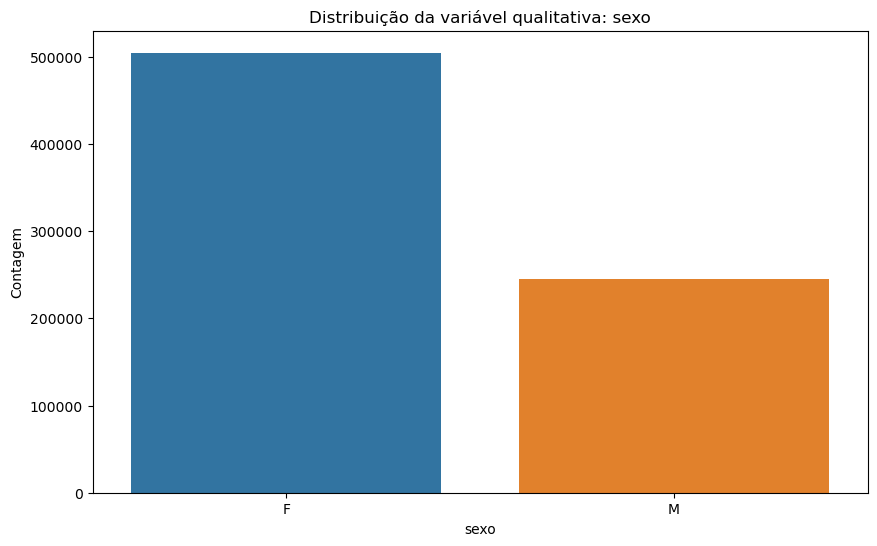

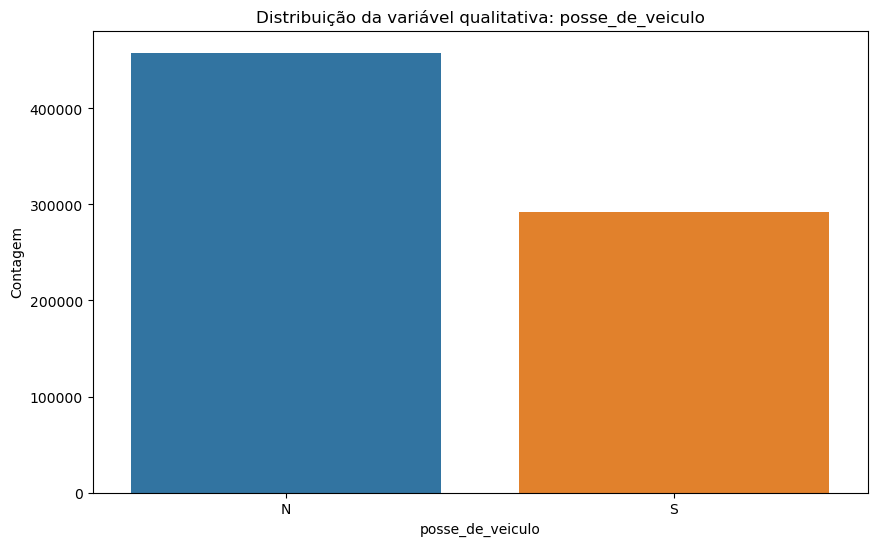

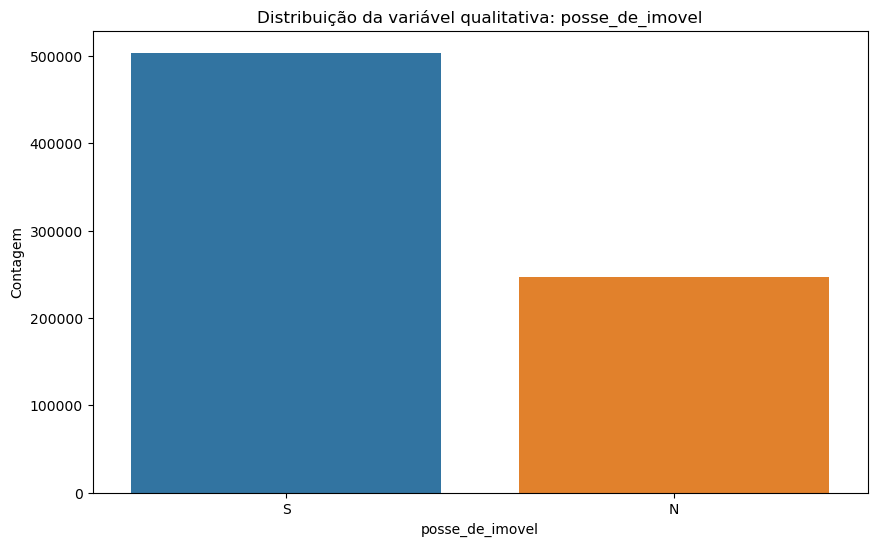

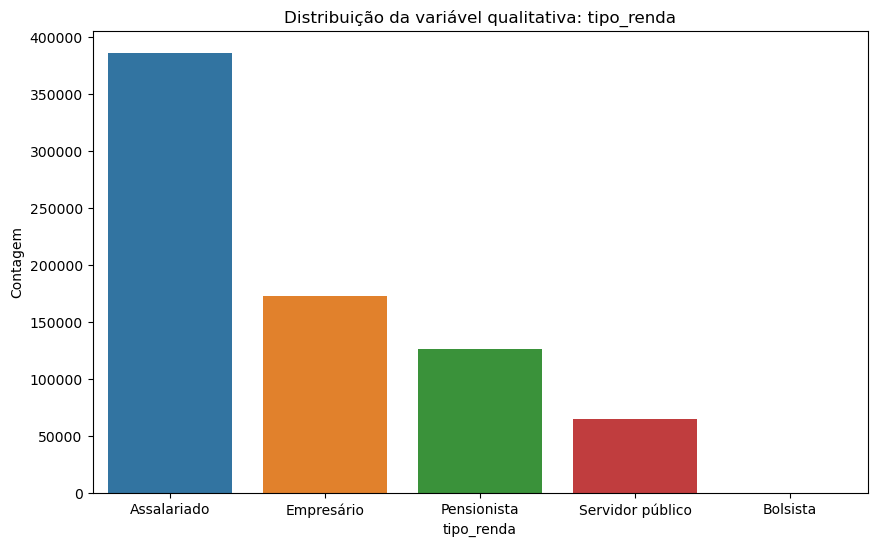

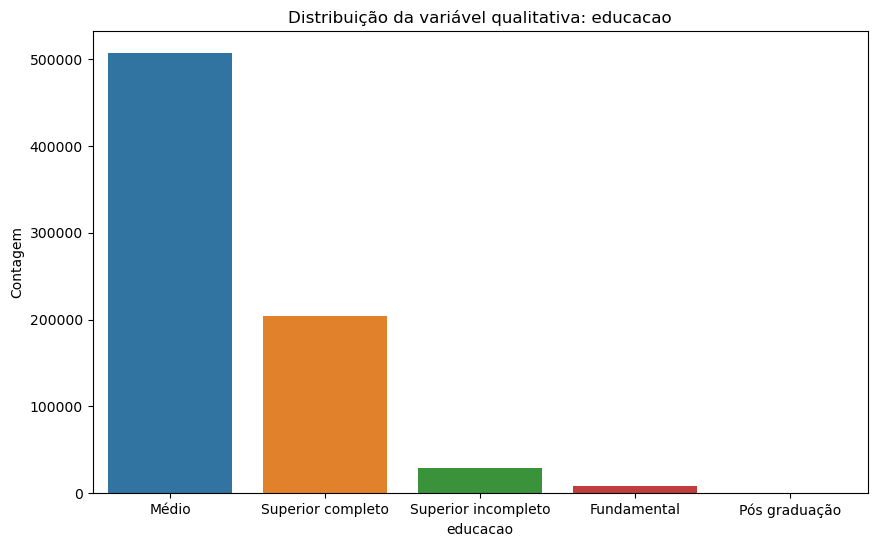

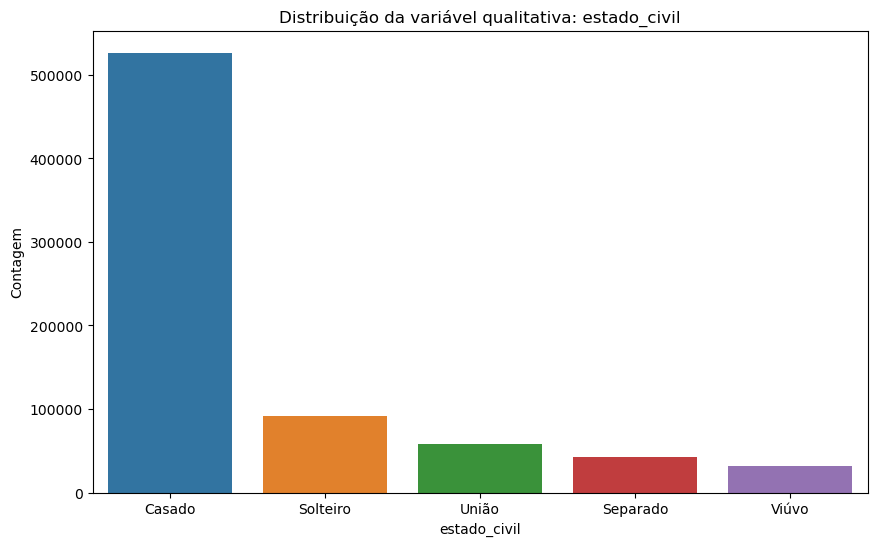

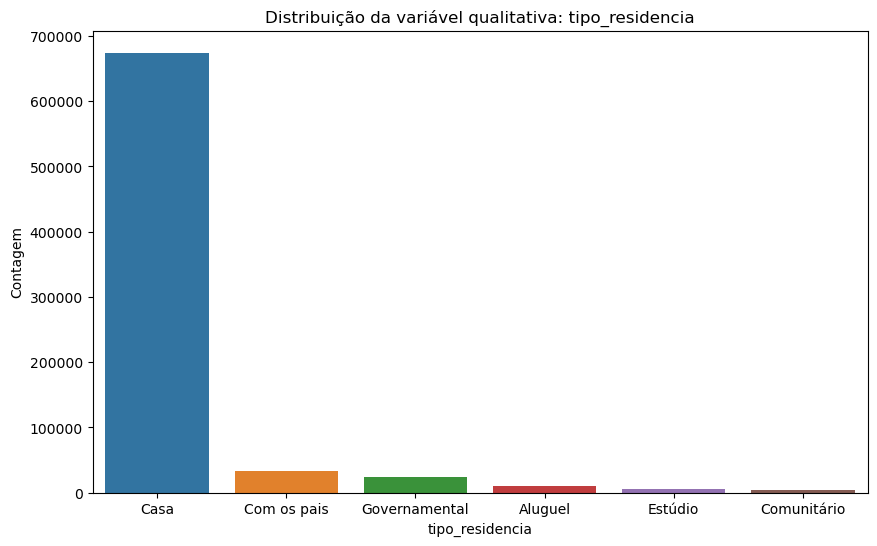

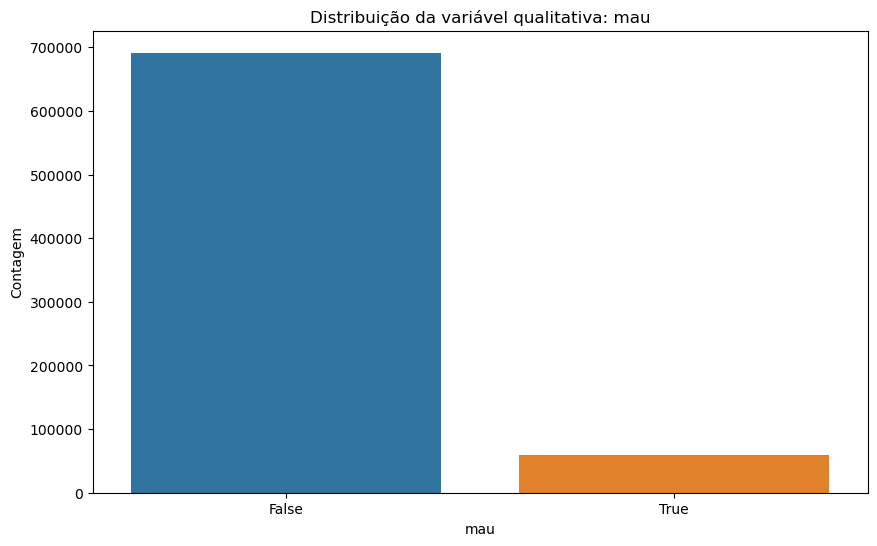

In [13]:
# Gráficos para variáveis qualitativas
for col in quali:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribuição da variável qualitativa: {col}')
    plt.xlabel(col)
    plt.ylabel('Contagem')
    plt.show()

In [14]:
# analise das variavveis quantitativas
quant= df.select_dtypes(include=['int64', 'float64']).columns
print(df[quant].describe())

               index     qtd_filhos          idade  tempo_emprego  \
count  750000.000000  750000.000000  750000.000000  624043.000000   
mean     8319.272793       0.433251      43.804733       7.748574   
std      4809.281774       0.739379      11.229868       6.687455   
min         0.000000       0.000000      22.000000       0.117808   
25%      4147.000000       0.000000      34.000000       3.049315   
50%      8324.000000       0.000000      43.000000       6.046575   
75%     12487.000000       1.000000      53.000000      10.183562   
max     16649.000000      14.000000      68.000000      42.906849   

       qt_pessoas_residencia         renda  
count          750000.000000  7.500000e+05  
mean                2.212241  2.323854e+04  
std                 0.903428  7.910601e+04  
min                 1.000000  1.076700e+02  
25%                 2.000000  3.467700e+03  
50%                 2.000000  7.861820e+03  
75%                 3.000000  1.831828e+04  
max               

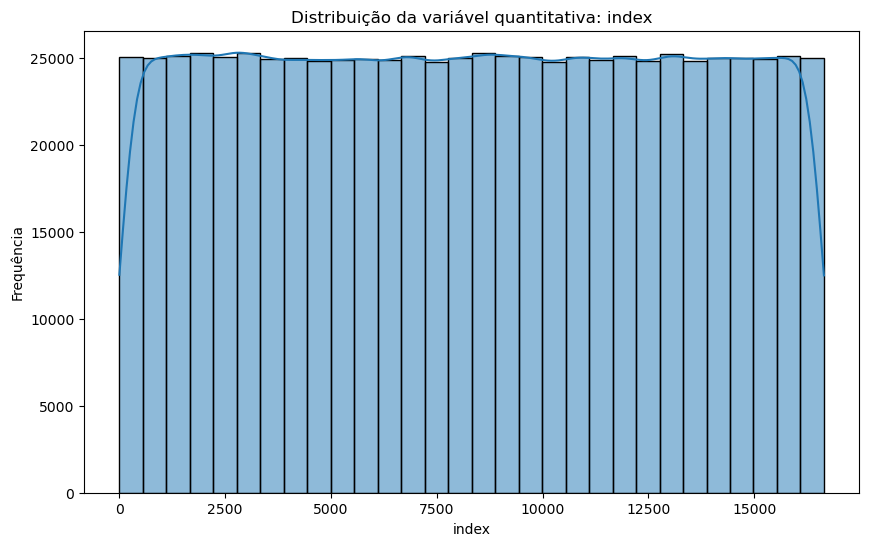

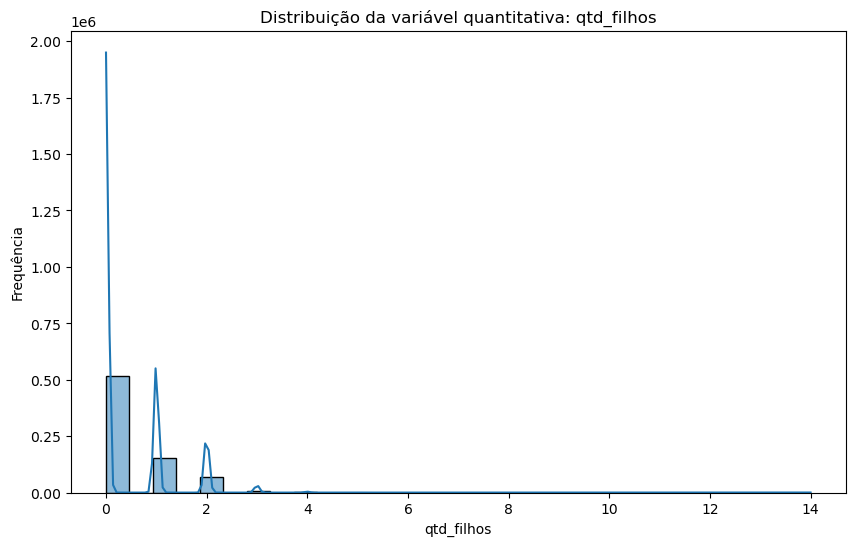

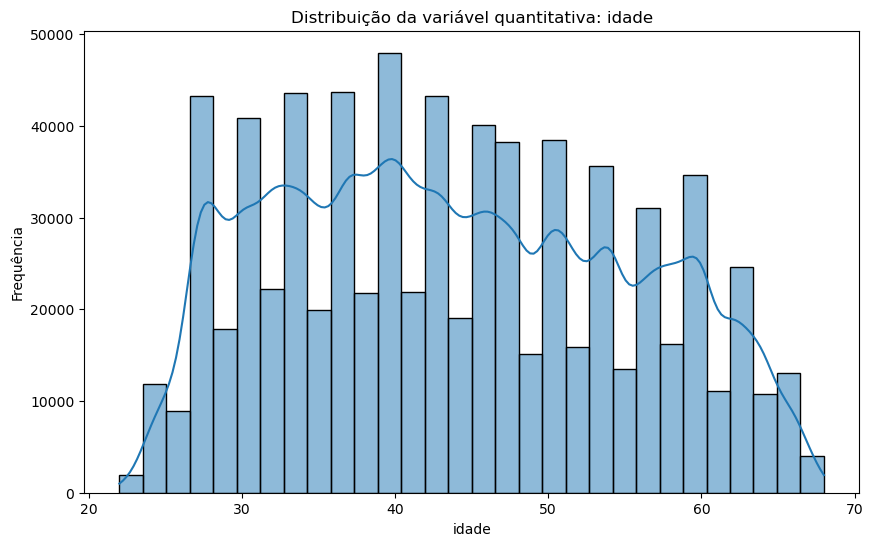

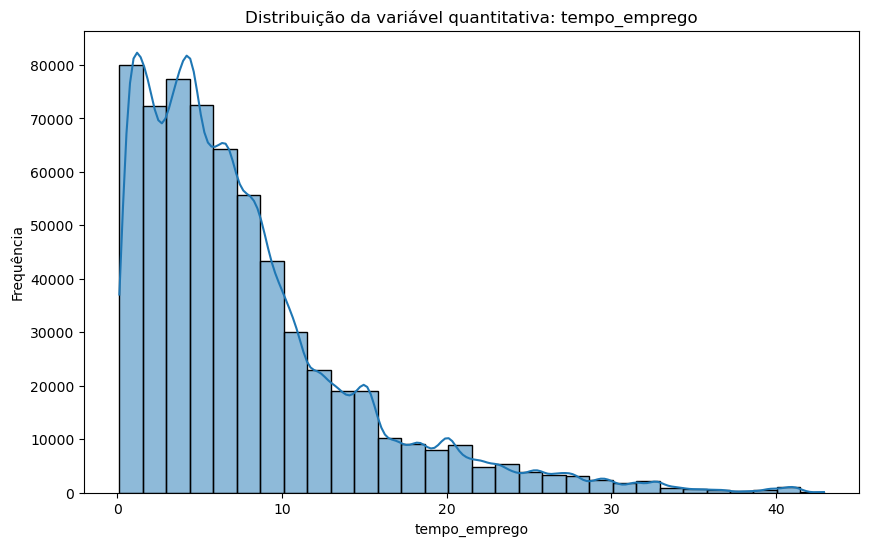

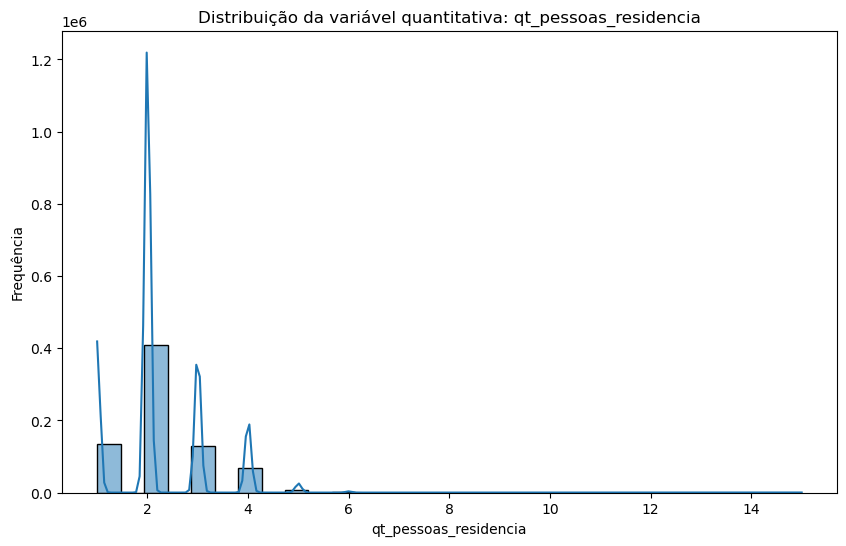

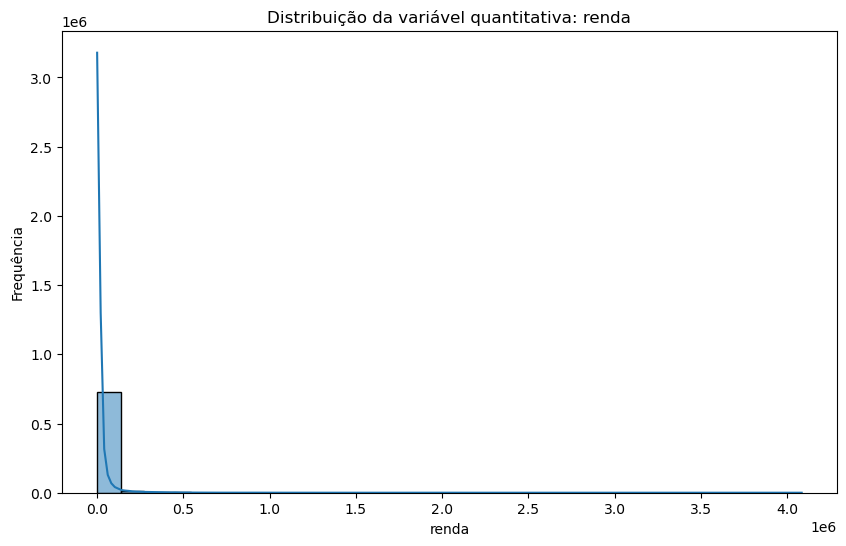

In [15]:
for col in quant:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribuição da variável quantitativa: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

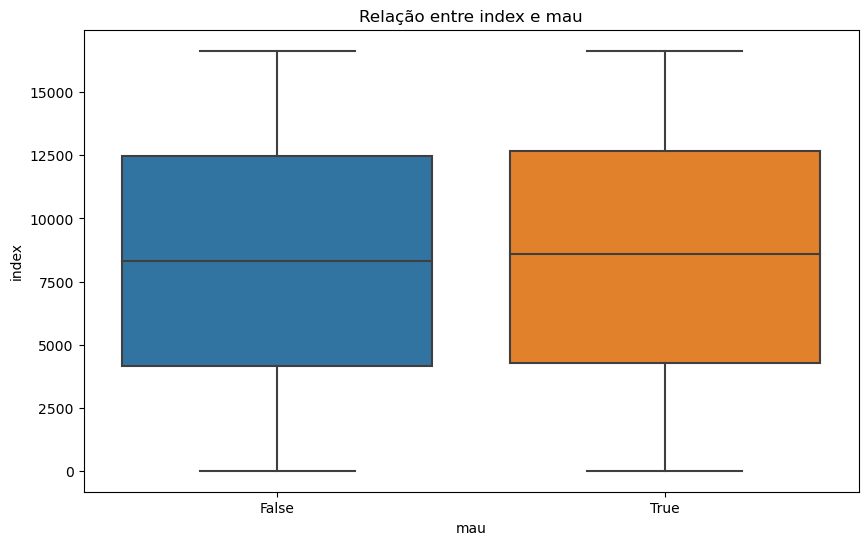

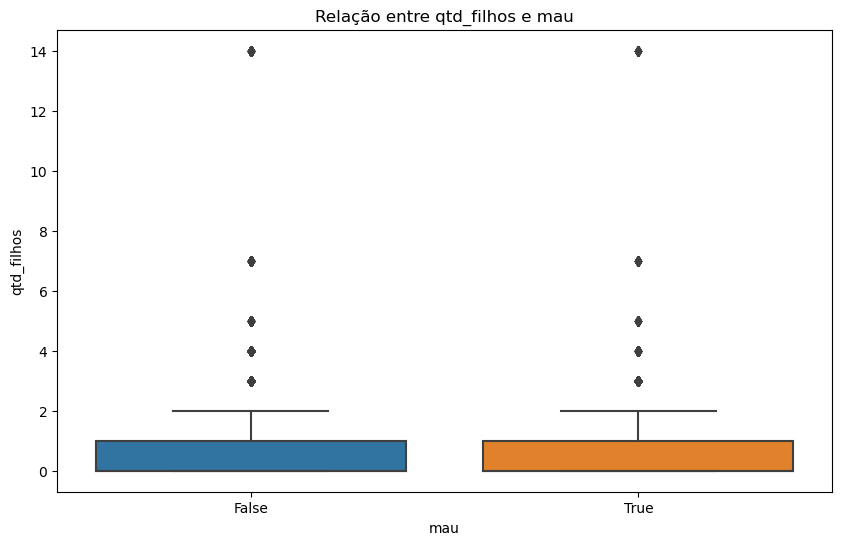

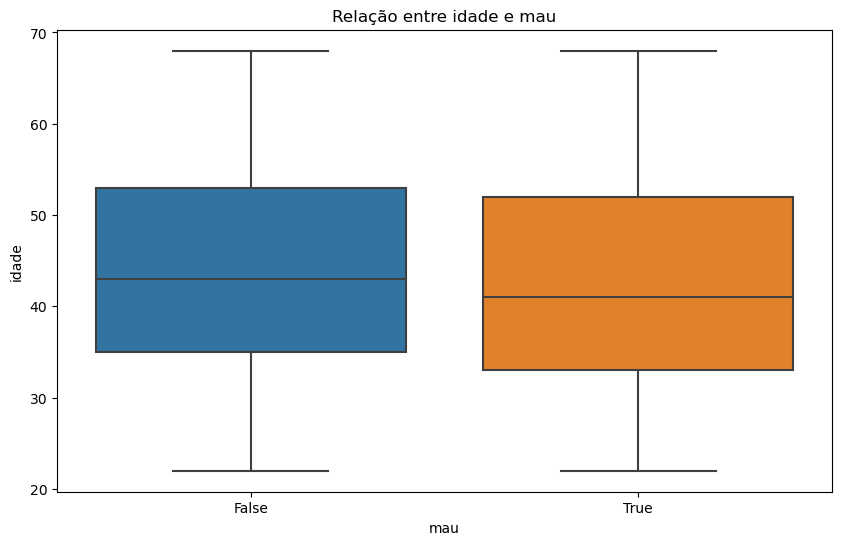

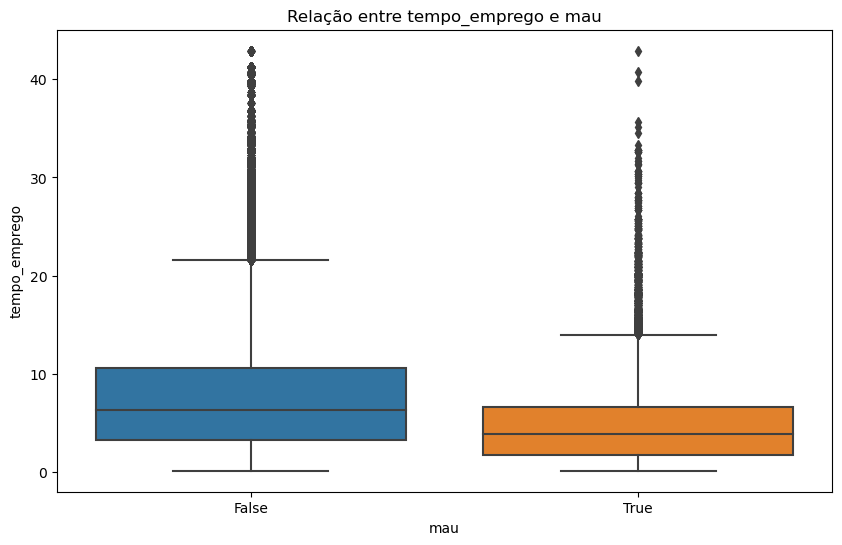

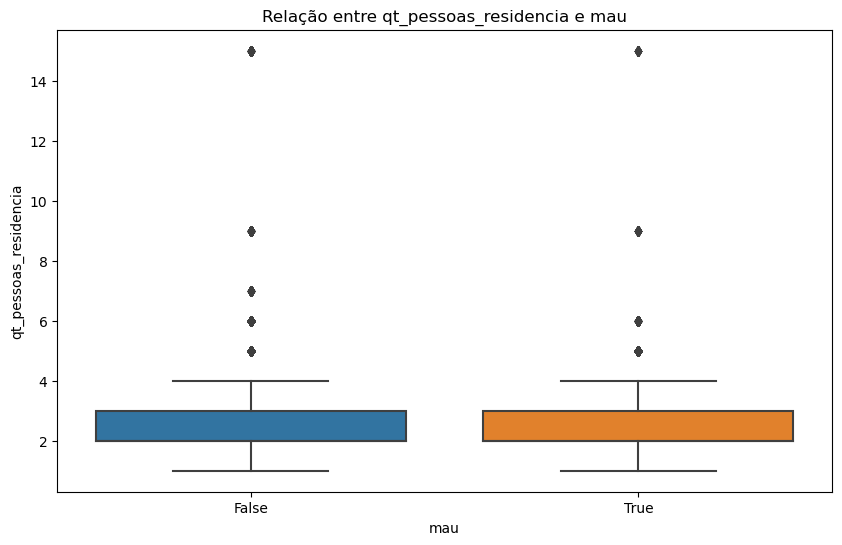

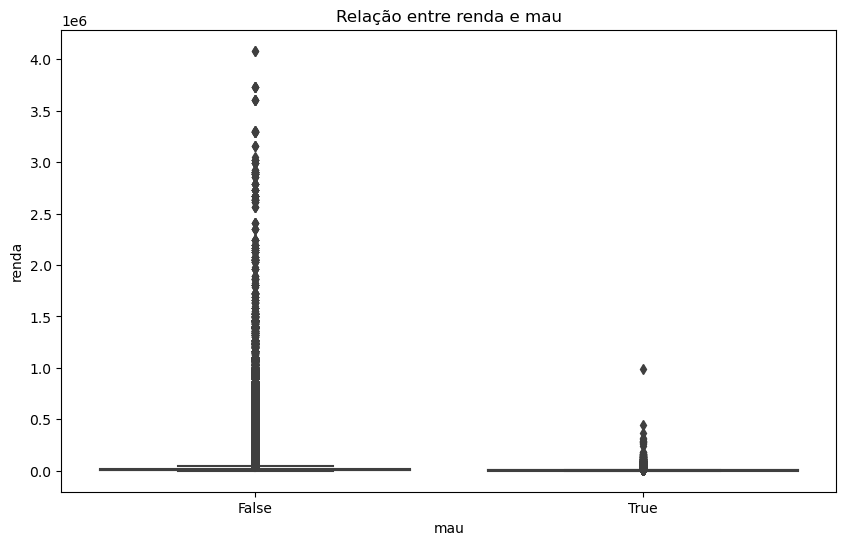

In [16]:
for col in quant:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='mau', y=col)
    plt.title(f'Relação entre {col} e mau')
    plt.xlabel('mau')
    plt.ylabel(col)
    plt.show()

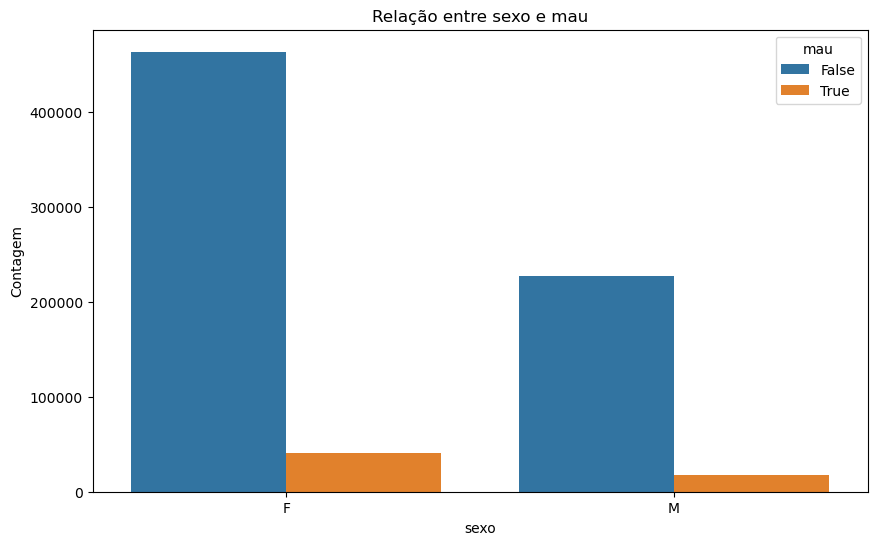

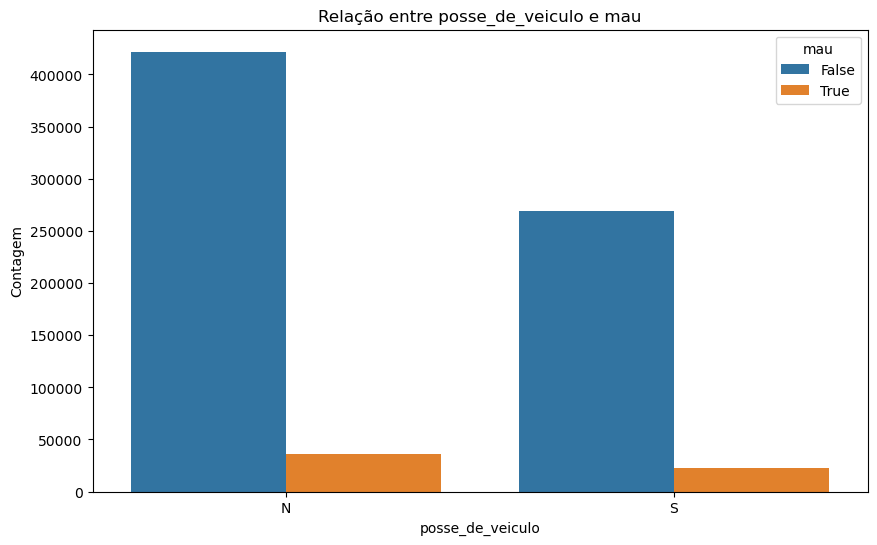

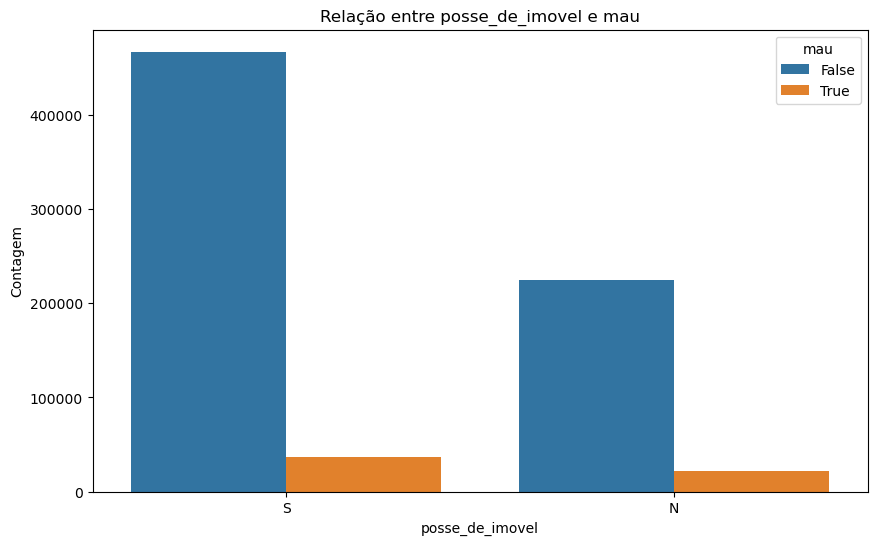

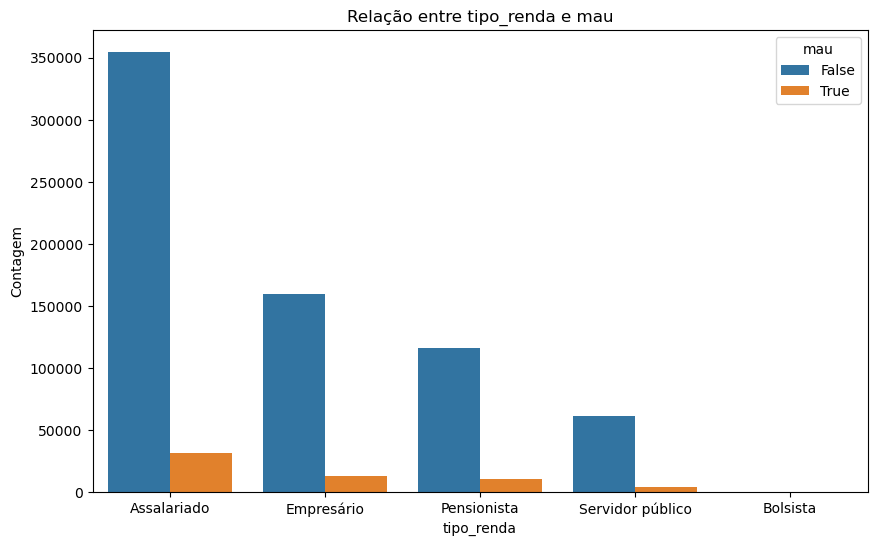

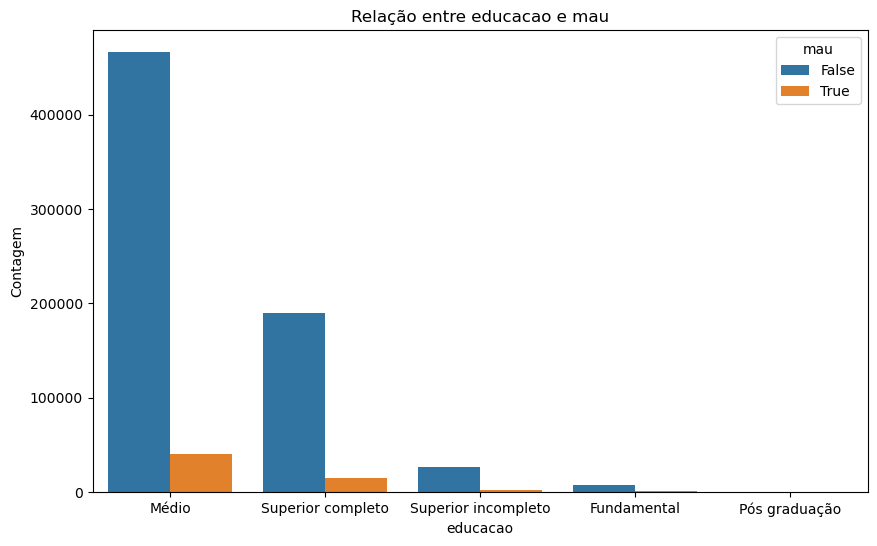

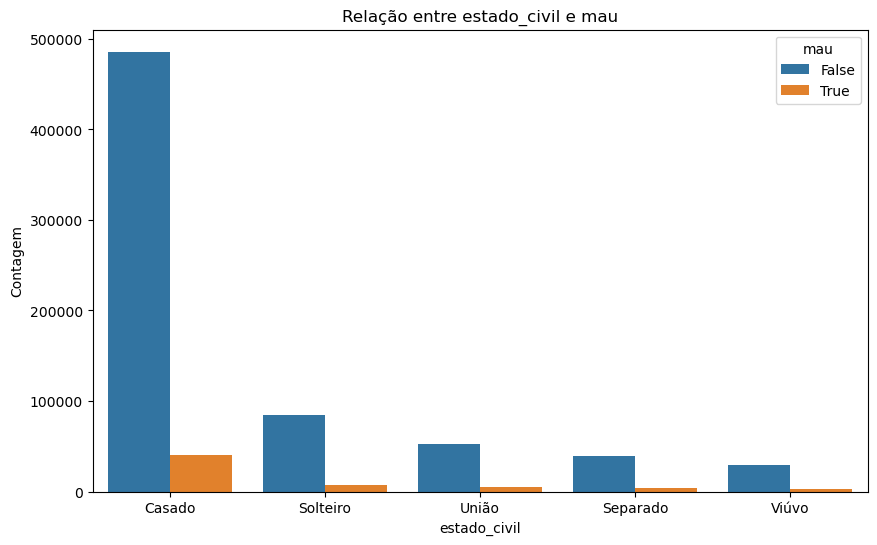

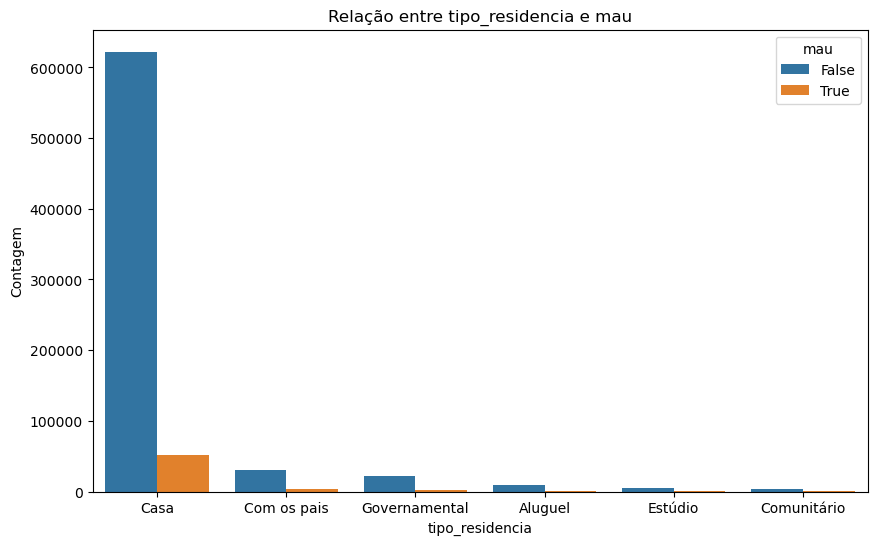

In [17]:
# qualitativas
for col in quali:
    if col != 'mau':
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col, hue='mau', order=df[col].value_counts().index)
        plt.title(f'Relação entre {col} e mau')
        plt.xlabel(col)
        plt.ylabel('Contagem')
        plt.legend(title='mau', loc='upper right')
        plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [18]:
# 8. Avaliar o modelo
df_treino['pred_prob'] = model.predict(df_treino)
df_treino['pred_class'] = (df_treino['pred_prob'] >= 0.5).astype(int)

accuracy = metrics.accuracy_score(df_treino['mau'], df_treino['pred_class'])
print(f"Acurácia do modelo: {accuracy:.2f}")

# 9. Exibir coeficientes do modelo
coef_df = pd.DataFrame({'Variável': model.params.index, 'Coeficiente': model.params.values})
print(coef_df)


NameError: name 'model' is not defined

In [ ]:
# verificando dados missing
df_treino.isnull().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

In [ ]:
# substituindo missing por media
df_treino['tempo_emprego'].fillna(df_treino['tempo_emprego'].mean(), inplace=True)

In [ ]:
df_treino.isnull().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

In [ ]:
# Identificar variáveis com outliers usando o método IQR
outlier = []
for col in quant:
    Q1 = df_treino[col].quantile(0.25)
    Q3 = df_treino[col].quantile(0.75)
    IQR = Q3 - Q1
    inferior = Q1 - 1.5 * IQR
    superior = Q3 + 1.5 * IQR
    outliers = df_treino[(df_treino[col] < inferior) | (df_treino[col] > superior)]
    if not outliers.empty:
        outlier.append(col)

In [ ]:
print(f"Variáveis com possíveis outliers: {outlier}")

Variáveis com possíveis outliers: ['qtd_filhos', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']


In [ ]:
# Tratando os outliers
df_treino['renda'] = np.clip(df_treino['renda'], a_min=None, a_max=df_treino['renda'].quantile(0.99))
df_treino['qt_pessoas_residencia'] = np.clip(df_treino['qt_pessoas_residencia'], a_min=None, a_max=df_treino['qt_pessoas_residencia'].quantile(0.99))
df_treino['tempo_emprego'] = np.clip(df_treino['tempo_emprego'], a_min=None, a_max=df_treino['tempo_emprego'].quantile(0.99))
df_treino['qtd_filhos'] = np.clip(df_treino['qtd_filhos'], a_min=None, a_max=df_treino['qtd_filhos'].quantile(0.99))

In [ ]:
# agrupando categorias raras
df_treino['educacao'] = df_treino['educacao'].replace(['Superior incompleto', 'Médio incompleto'], 'Outros')
df_treino['estado_civil'] = df_treino['estado_civil'].replace(['Separado', 'Viúvo', 'União'], 'Outros')
df_treino['tipo_renda'] = df_treino['tipo_renda'].replace(['Pensionista', 'Bolsista'], 'Outros')
df_treino['tipo_residencia'] = df_treino['tipo_residencia'].replace(['Comunitário', 'Aluguel', 'Estúdio'], 'Outros')

In [ ]:
df_treino['mau'] = df_treino['mau'].astype(int)

In [ ]:
# treinando modelo
modelo = smf.logit(formula='''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda +
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego +
    renda
''', data=df_treino).fit()

Optimization terminated successfully.
         Current function value: 0.208003
         Iterations 10


In [ ]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                          Logit   Df Residuals:                   599980
Method:                           MLE   Df Model:                           19
Date:                Wed, 16 Apr 2025   Pseudo R-squ.:                 0.09527
Time:                        09:12:37   Log-Likelihood:            -1.2480e+05
converged:                       True   LL-Null:                   -1.3794e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.4567      0.058    -25.058      0.000      -1.571      -1.343
sexo[T.M]                           -0.1233      0.013     -9.404      0.000      -0.149      -0.098
posse_de_veiculo[T.S]                0.0311      0.012      2.511      0.012       0.007       0.055
posse_de_imovel[T.S]                -0.0853      0.012     -7.217      0.000      -0.108      -0.062
tipo_renda[T.Empresário]            -0.0509      0.014     -3.639      0.000      -0.078      -0.023
tipo_renda[T.Outros]                -0.0433      0.020     -2.151      0.031      -0.083      -0.004
tipo_renda[T.Servidor público]      -0.0322      0.023     -1.386      0.166      -0.078       0.013
educacao[T.Médio]                   -0.0270      0.049     -0.556      0.578      -0.122       0.068
educacao[T.Outros]                  -0.0779      0.056     -1.400      0.162      -0.187       0.031
educacao[T.Pós graduação]           -0.0421      0.168     -0.251      0.802      -0.371       0.287
educacao[T.Superior completo]       -0.0872      0.050     -1.755      0.079      -0.185       0.010
estado_civil[T.Outros]               0.0269      0.015      1.828      0.068      -0.002       0.056
estado_civil[T.Solteiro]             0.0067      0.017      0.386      0.699      -0.027       0.041
tipo_residencia[T.Com os pais]       0.0150      0.025      0.595      0.552      -0.034       0.064
tipo_residencia[T.Governamental]     0.0023      0.031      0.072      0.942      -0.059       0.064
tipo_residencia[T.Outros]            0.0537      0.034      1.575      0.115      -0.013       0.120
qtd_filhos                           0.0022      0.008      0.257      0.797      -0.014       0.019
idade                               -0.0001      0.001     -0.191      0.849      -0.002       0.001
tempo_emprego                       -0.0231      0.002    -12.832      0.000      -0.027      -0.020
renda                               -0.0001   1.09e-06    -94.062      0.000      -0.000      -0.000
====================================================================================================
"""

*Apenas as variaveis sexo, posse veículo, posse imovel, tipo renda, tempo emprego e renda tem p-valor menor que 0.05, portanto vou deixar apenas elas e ver como o modelo vai performar*

In [ ]:
'sexo', 'posse_de_veiculo','posse_de_imovel','tipo_renda','tempo_emprego', 'renda'

In [ ]:
modelo_2 = smf.logit(formula='''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + tipo_renda +
    tempo_emprego + renda''', data=df_treino).fit()

Optimization terminated successfully.
         Current function value: 0.208027
         Iterations 10


In [ ]:
modelo_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                          Logit   Df Residuals:                   599991
Method:                           MLE   Df Model:                            8
Date:                Wed, 16 Apr 2025   Pseudo R-squ.:                 0.09517
Time:                        09:22:48   Log-Likelihood:            -1.2482e+05
converged:                       True   LL-Null:                   -1.3794e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.4918      0.015   -102.428      0.000      -1.520      -1.463
sexo[T.M]                         -0.1199      0.013     -9.248      0.000      -0.145      -0.094
posse_de_veiculo[T.S]              0.0231      0.012      1.901      0.057      -0.001       0.047
posse_de_imovel[T.S]              -0.0865      0.011     -7.524      0.000      -0.109      -0.064
tipo_renda[T.Empresário]          -0.0583      0.014     -4.203      0.000      -0.086      -0.031
tipo_renda[T.Outros]              -0.0410      0.016     -2.514      0.012      -0.073      -0.009
tipo_renda[T.Servidor público]    -0.0447      0.023     -1.939      0.052      -0.090       0.000
tempo_emprego                     -0.0230      0.002    -12.854      0.000      -0.026      -0.019
renda                             -0.0001   1.09e-06    -94.422      0.000      -0.000      -0.000
==================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [ ]:
# Funçao para calcular o ks
def calcula_ks(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return max(tpr - fpr)

In [ ]:
# Função para calcular o Gini
def calcula_gini(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

In [ ]:
df_treino['pred_prob'] = modelo_2.predict(df_treino)
df_treino['pred_class'] = (df_treino['pred_prob'] >= 0.5).astype(int)

In [ ]:
acuracia_treino = accuracy_score(df_treino['mau'], df_treino['pred_class'])
ks_treino = calcula_ks(df_treino['mau'], df_treino['pred_prob'])
gini_treino = calcula_gini(df_treino['mau'], df_treino['pred_prob'])

In [ ]:
print(f"Treino -  Accuracy: {accuracy_dev:.2f}, KS: {ks_dev:.2f}, Gini: {gini_dev:.2f}")

Treino -  Accuracy: 0.94, KS: 0.39, Gini: 0.53


In [ ]:
# agrupando categorias raras no teste
df_oot['educacao'] = df_oot['educacao'].replace(['Superior incompleto', 'Médio incompleto'], 'Outros')
df_oot['estado_civil'] = df_oot['estado_civil'].replace(['Separado', 'Viúvo', 'União'], 'Outros')
df_oot['tipo_renda'] = df_oot['tipo_renda'].replace(['Pensionista', 'Bolsista'], 'Outros')
df_oot['tipo_residencia'] = df_oot['tipo_residencia'].replace(['Comunitário', 'Aluguel', 'Estúdio'], 'Outros')

In [ ]:
df_oot['mau'] = df_oot['mau'].astype(int)

In [ ]:
df_oot = df_oot.dropna(subset=['mau', 'pred_prob'])

In [ ]:
# Evaluate on out-of-time dataset
df_oot['pred_prob'] = modelo_2.predict(df_oot)
df_oot['pred_class'] = (df_oot['pred_prob'] >= 0.5).astype(int)

In [ ]:
acuracia_oot = accuracy_score(df_oot['mau'], df_oot['pred_class'])
ks_oot = calcula_ks(df_oot['mau'], df_oot['pred_prob'])
gini_oot = calcula_gini(df_oot['mau'], df_oot['pred_prob'])

In [ ]:
print(f"Teste out of time - Accuracy: {accuracy_oot:.2f}, KS: {ks_oot:.2f}, Gini: {gini_oot:.2f}")

Teste out of time - Accuracy: 0.86, KS: 0.35, Gini: 0.47
